# 

In [1]:
!pip install -Uqq ddgs fastai "numpy<2.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [2]:
from fastai.vision.all import *

Lets download the fractures files and set the path variable to point to the root

Path to dataset files: /kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection
/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/train/images/6_jpg.rf.2f66adec11758de70ce9c84e7c4596d0.jpg


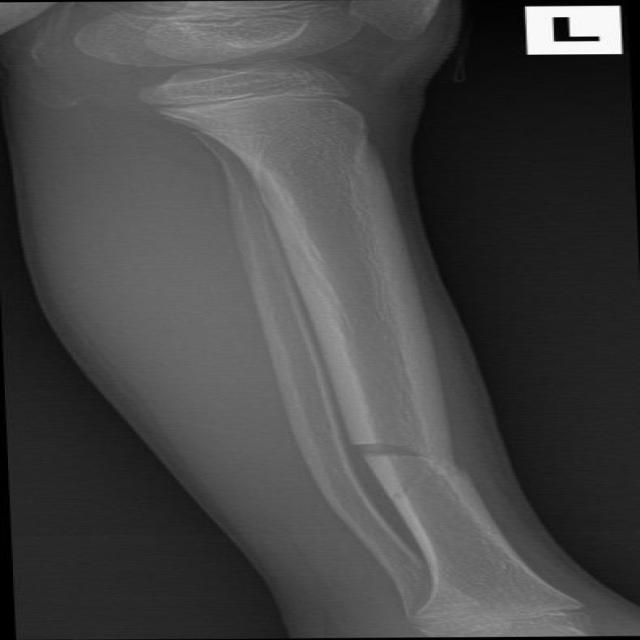

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jockeroika/human-bone-fractures-image-dataset")

path = Path("/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection")
print("Path to dataset files:", path)

image1 = (path/'train'/'images').ls()[0]
print(image1)

Image.open(image1)

Lets map the label ids into their actual descriptions


In [4]:
class_names = [
    'Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced',
    'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse'
]

Now lets create a function that correctly maps any of the images fed into the model, to it's label.

In [5]:
def label_function(filepath):
    directory = filepath.parent.parent #eg train, valid, test
    filestem = filepath.stem

    labelfile = directory/'labels'/(filestem + ".txt")

    with open(labelfile, 'r') as file:
        
        firstline = file.readline().strip().split(' ')
        return class_names[int(firstline[0])]

Test it out with a file to be sure:

In [6]:
label_function(image1)

'Greenstick'

Test it out with a couple more

In [7]:
images = (path/'train'/'images').ls()[:410]


res = list(map(label_function, images))
print(res)

['Greenstick', 'Comminuted', 'Oblique Displaced', 'Oblique Displaced', 'Linear', 'Transverse Displaced', 'Transverse Displaced', 'Transverse Displaced', 'Transverse', 'Transverse Displaced', 'Transverse Displaced', 'Comminuted', 'Transverse', 'Linear', 'Comminuted', 'Transverse', 'Oblique Displaced', 'Transverse', 'Oblique Displaced', 'Transverse Displaced', 'Transverse Displaced', 'Transverse Displaced', 'Healthy', 'Healthy', 'Transverse', 'Transverse Displaced', 'Greenstick', 'Comminuted', 'Comminuted', 'Oblique', 'Oblique Displaced', 'Transverse Displaced', 'Transverse Displaced', 'Spiral', 'Transverse Displaced', 'Transverse Displaced', 'Transverse Displaced', 'Transverse Displaced', 'Comminuted', 'Oblique Displaced', 'Spiral', 'Oblique Displaced', 'Spiral', 'Transverse Displaced', 'Transverse Displaced', 'Comminuted', 'Comminuted', 'Oblique Displaced', 'Transverse Displaced', 'Transverse Displaced', 'Healthy', 'Oblique Displaced', 'Transverse Displaced', 'Transverse Displaced', 'T

Now lets train

In [8]:
train_path =  (path/'train'/'images')
valid_path = (path/'valid'/'images')

train_files = [f for f in get_image_files(train_path) if (f.parent.parent/'labels'/(f.stem+'.txt')).stat().st_size > 0]
valid_files = [f for f in get_image_files(valid_path) if (f.parent.parent/'labels'/(f.stem+'.txt')).stat().st_size > 0]
all_files = train_files + valid_files


In [9]:
block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: all_files,
    get_y=label_function,
    splitter=FuncSplitter(lambda o: o in valid_files),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

In [10]:
# pass train_path because splitter handles valid_path
dls = block.dataloaders(train_path, bs=16)

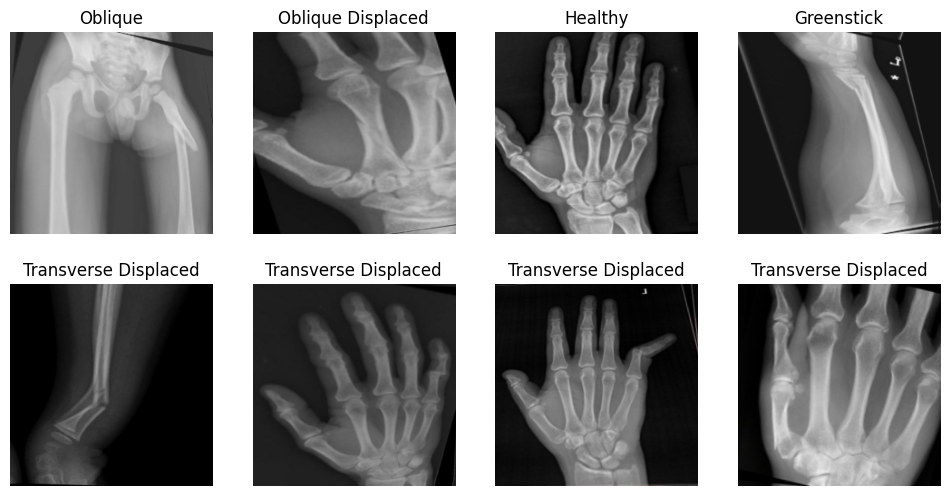

In [11]:
dls.show_batch(max_n = 8)

In [12]:
learn = vision_learner(
    dls, 
    resnet34,        
    metrics=accuracy
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 193MB/s]


SuggestedLRs(valley=0.0030199517495930195)

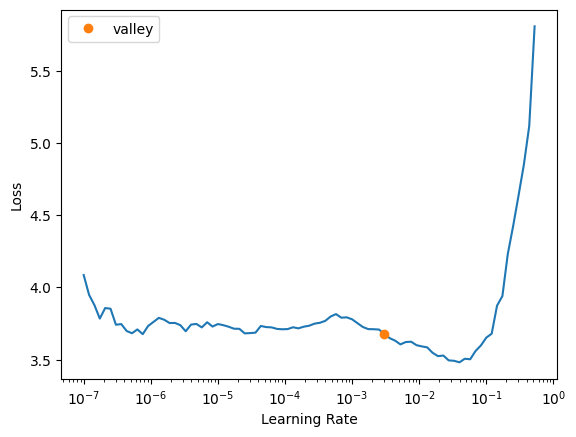

In [13]:
learn.lr_find()


In [14]:
learn.fine_tune(5, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.439266,1.856815,0.515625,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.657884,2.020254,0.539062,00:07
1,1.587261,1.269522,0.625000,00:07
2,1.150971,0.779194,0.726562,00:07
3,0.714525,0.519499,0.828125,00:07
4,0.445959,0.342385,0.914062,00:07


In [15]:
test_path = (path/'test'/'images')
test_files = [f for f in get_image_files(test_path) if (f.parent.parent/'labels'/(f.stem+'.txt')).stat().st_size > 0]



img = PILImage.create(test_files[0])
pred_class, pred_idx, outputs = learn.predict(img)
print(f"Prediction: {pred_class}, Probability: {outputs[pred_idx]:.4f}")


Prediction: Transverse Displaced, Probability: 0.8722


In [16]:
learn.export('/kaggle/working/export.pkl')